In [1]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
import tensorflow as tf


from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, GRU

In [ ]:
#!pip install librosa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
augmented_path = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MLA Project/aug_final_df.csv')
non_augmented_path = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MLA Project/final_df.csv')
merged_data_path = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MLA Project/merged_df.csv')
#merged_data_path = pd.read_csv('merged_df.csv')
#non_augmented_path = pd.read_csv('final_df.csv')
#augmented_path = pd.read_csv('aug_final_df.csv')

# data_path = pd.read_csv('aug_final_df.csv')
# clean_data_path = pd.read_csv('final_df.csv')
non_augmented_path.drop(columns=['Unnamed: 0', 'Emotions_without_gender'], axis=1, inplace=True)
non_augmented_path.rename(columns={"Emotions_with_gender": "Emotions"}, inplace=True)

In [6]:
# Train test split

# For non-aug data
X_na = non_augmented_path.drop(columns=['Path','Emotions'], axis=1)
y_na = non_augmented_path['Emotions']
print("Non-Augmented Data shape:")
print(X_na.shape, y_na.shape)

# For aug data
X_a = augmented_path.drop(columns=['Emotions', 'Path'])
y_a = augmented_path['Emotions']
print("Augmented Data shape:")
print(X_a.shape, y_a.shape)

# For merged data (non-aug + aug)
X_merge = merged_data_path.drop(columns=['Path','Emotions'], axis=1)
y_merge = merged_data_path['Emotions']
print("Merge Data shape:")
print(X_merge.shape, y_merge.shape)


Non-Augmented Data shape:
(11682, 173) (11682,)
Augmented Data shape:
(11682, 173) (11682,)
Merge Data shape:
(23364, 174) (23364,)


In [7]:
augmented_path = shuffle(augmented_path)
augmented_path.tail()

,Emotions,Path,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,...,MEL124,MEL125,MEL126,MEL127,TONZ0,TONZ1,TONZ2,TONZ3,TONZ4,TONZ5
4236,14,Crema\1035_IOM_SAD_XX.wav,-436.827325,90.043552,50.210083,34.307580,16.504013,10.742488,2.556842,4.169943,...,0.000023,0.000023,0.000023,0.000021,-0.021039,-0.001664,-0.036575,0.026833,0.023896,-0.016083
4705,13,Crema\1041_DFA_NEU_XX.wav,-403.485001,99.586354,36.546396,37.617400,13.191015,5.380179,-10.212090,-5.502306,...,0.000017,0.000018,0.000018,0.000020,0.017164,-0.006766,-0.091187,-0.002901,0.035332,0.012821
4951,13,Crema\1044_DFA_NEU_XX.wav,-314.851137,74.994278,26.382227,30.930681,11.984166,1.307382,-2.281117,-2.560755,...,0.000217,0.000213,0.000216,0.000219,0.008267,-0.004497,-0.056991,-0.059814,0.011548,-0.006660
447,4,Ravdess\03-01-03-02-02-01-16.wav,-307.910660,11.252178,-0.210933,0.717286,-2.364602,-7.073826,-7.563673,-6.424717,...,0.004660,0.003602,0.002516,0.001153,-0.014603,-0.006745,-0.013431,-0.009315,0.006673,-0.007210
318,12,Ravdess\03-01-03-01-01-02-07.wav,-489.406710,30.373909,1.721076,7.030166,3.723308,-5.015921,-7.873989,-4.671217,...,0.000021,0.000021,0.000018,0.000018,0.040368,-0.007653,-0.047739,0.053716,0.005369,-0.015543


In [8]:
# X = augmented_path.drop(columns=['Emotions', 'Path'])
# y = augmented_path['Emotions']
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html

# Using augmented dataset here
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print(X_smote.shape, y_smote.shape)

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(X_ros.shape, y_ros.shape)

(14112, 173) (14112,)
(14112, 173) (14112,)


In [9]:
def build_model(input_shape):
    model =  keras.Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(16, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_v2(input_shape):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(16, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_LSTM(input_shape):
    model = keras.Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128))
    model.add(Dense(16, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_GRU(input_shape):
    model = keras.Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(GRU(128))
    model.add(Dense(16, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_LSTM_GRU(input_shape):
    model = keras.Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(GRU(128))
    model.add(Dense(16, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def get_mel_spectrogram(df):
    return df.filter(like='MEL')

Epoch 1/50
353/353 [==============================] - 10s 17ms/step - loss: 2.7049 - accuracy: 0.0818 - val_loss: 3.3196 - val_accuracy: 0.0000e+00
Epoch 2/50
353/353 [==============================] - 9s 25ms/step - loss: 2.5573 - accuracy: 0.1355 - val_loss: 3.3287 - val_accuracy: 0.0014
Epoch 3/50
353/353 [==============================] - 9s 25ms/step - loss: 2.2500 - accuracy: 0.2303 - val_loss: 3.0518 - val_accuracy: 0.1619
Epoch 4/50
353/353 [==============================] - 7s 20ms/step - loss: 2.1678 - accuracy: 0.2587 - val_loss: 2.6672 - val_accuracy: 0.1913
Epoch 5/50
353/353 [==============================] - 8s 24ms/step - loss: 2.1135 - accuracy: 0.2759 - val_loss: 2.4633 - val_accuracy: 0.1428
Epoch 6/50
353/353 [==============================] - 7s 20ms/step - loss: 2.0396 - accuracy: 0.3139 - val_loss: 2.4728 - val_accuracy: 0.1477
Epoch 7/50
353/353 [==============================] - 6s 17ms/step - loss: 1.9632 - accuracy: 0.3379 - val_loss: 2.5425 - val_accuracy: 0

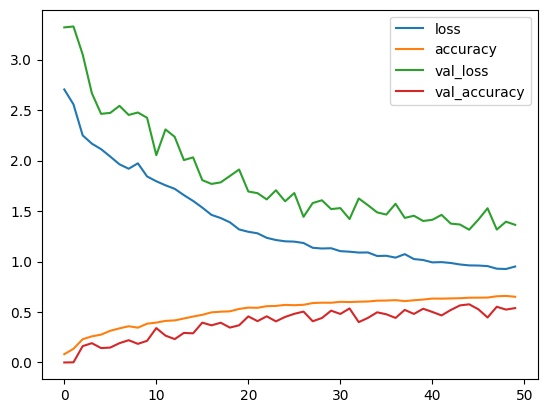

0.5763372182846069


In [10]:

model_smote = build_model((X_smote.shape[1], 1))
# Validation split https://youtu.be/dzoh8cfnvnI?si=dL3Xhac5PKAUnbFT
# Shuffle to make the batch random
smote_history = model_smote.fit(X_smote, y_smote, validation_split=0.2, shuffle=True, epochs=50)

# summarize history for accuracy
pd.DataFrame(smote_history.history).plot()
plt.show()

best_score = max(smote_history.history['val_accuracy'])

print(best_score)


Epoch 1/50
353/353 [==============================] - 10s 18ms/step - loss: 2.4538 - accuracy: 0.1732 - val_loss: 3.3589 - val_accuracy: 0.0000e+00
Epoch 2/50
353/353 [==============================] - 5s 15ms/step - loss: 2.2246 - accuracy: 0.2425 - val_loss: 2.9785 - val_accuracy: 0.1392
Epoch 3/50
353/353 [==============================] - 6s 17ms/step - loss: 2.2181 - accuracy: 0.2384 - val_loss: 2.8683 - val_accuracy: 0.1835
Epoch 4/50
353/353 [==============================] - 5s 14ms/step - loss: 2.2230 - accuracy: 0.2423 - val_loss: 2.9213 - val_accuracy: 0.0871
Epoch 5/50
353/353 [==============================] - 6s 17ms/step - loss: 2.1382 - accuracy: 0.2733 - val_loss: 2.8968 - val_accuracy: 0.1977
Epoch 6/50
353/353 [==============================] - 5s 15ms/step - loss: 2.1074 - accuracy: 0.2900 - val_loss: 2.8189 - val_accuracy: 0.1824
Epoch 7/50
353/353 [==============================] - 6s 16ms/step - loss: 2.0887 - accuracy: 0.2991 - val_loss: 2.6455 - val_accuracy: 0

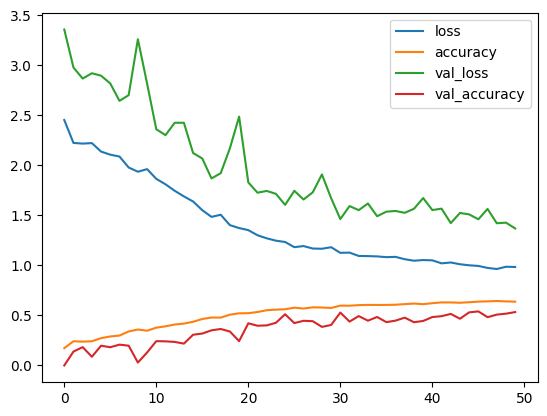

0.540559709072113


In [11]:
model_ros = build_model((X_ros.shape[1], 1))

ros_history = model_ros.fit(X_ros, y_ros, validation_split=0.2, shuffle=True, epochs=50)

# summarize history for accuracy
pd.DataFrame(ros_history.history).plot()
plt.show()

best_score = max(ros_history.history['val_accuracy'])

print(best_score)

Epoch 1/50
353/353 [==============================] - 18s 32ms/step - loss: 2.0080 - accuracy: 0.3322 - val_loss: 2.0652 - val_accuracy: 0.3107
Epoch 2/50
353/353 [==============================] - 10s 29ms/step - loss: 1.6383 - accuracy: 0.4450 - val_loss: 1.7467 - val_accuracy: 0.4162
Epoch 3/50
353/353 [==============================] - 10s 29ms/step - loss: 1.4876 - accuracy: 0.4877 - val_loss: 1.6713 - val_accuracy: 0.4159
Epoch 4/50
353/353 [==============================] - 10s 29ms/step - loss: 1.3498 - accuracy: 0.5299 - val_loss: 1.6367 - val_accuracy: 0.4322
Epoch 5/50
353/353 [==============================] - 10s 27ms/step - loss: 1.2459 - accuracy: 0.5622 - val_loss: 1.9735 - val_accuracy: 0.3153
Epoch 6/50
353/353 [==============================] - 10s 29ms/step - loss: 1.2070 - accuracy: 0.5729 - val_loss: 1.5139 - val_accuracy: 0.4821
Epoch 7/50
353/353 [==============================] - 10s 29ms/step - loss: 1.1722 - accuracy: 0.5848 - val_loss: 1.4190 - val_accuracy:

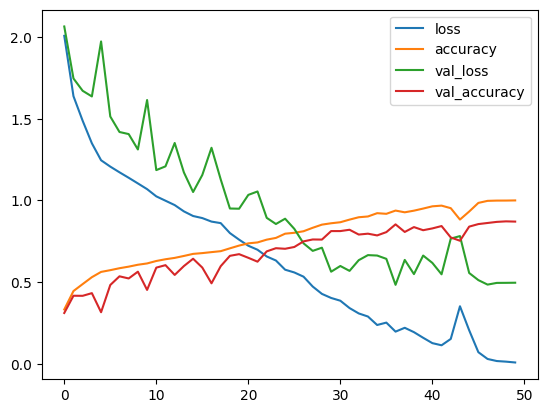

0.8717676401138306


In [12]:

model_smote_v2 = build_model_v2((X_smote.shape[1], 1))
# Validation split https://youtu.be/dzoh8cfnvnI?si=dL3Xhac5PKAUnbFT
# Shuffle to make the batch random
smote_history_v2 = model_smote_v2.fit(X_smote, y_smote, validation_split=0.2, shuffle=True, epochs=50)

# summarize history for accuracy
pd.DataFrame(smote_history_v2.history).plot()
plt.show()

best_score = max(smote_history_v2.history['val_accuracy'])

print(best_score)

Epoch 1/50
353/353 [==============================] - 18s 34ms/step - loss: 2.0253 - accuracy: 0.3253 - val_loss: 2.1669 - val_accuracy: 0.3156
Epoch 2/50
353/353 [==============================] - 11s 30ms/step - loss: 1.6633 - accuracy: 0.4349 - val_loss: 2.1343 - val_accuracy: 0.3000
Epoch 3/50
353/353 [==============================] - 10s 29ms/step - loss: 1.4955 - accuracy: 0.4876 - val_loss: 1.7068 - val_accuracy: 0.4414
Epoch 4/50
353/353 [==============================] - 10s 29ms/step - loss: 1.3444 - accuracy: 0.5299 - val_loss: 1.7486 - val_accuracy: 0.4205
Epoch 5/50
353/353 [==============================] - 10s 27ms/step - loss: 1.2636 - accuracy: 0.5529 - val_loss: 1.7007 - val_accuracy: 0.4102
Epoch 6/50
353/353 [==============================] - 11s 30ms/step - loss: 1.2215 - accuracy: 0.5663 - val_loss: 1.6183 - val_accuracy: 0.4591
Epoch 7/50
353/353 [==============================] - 10s 29ms/step - loss: 1.1800 - accuracy: 0.5795 - val_loss: 1.4528 - val_accuracy:

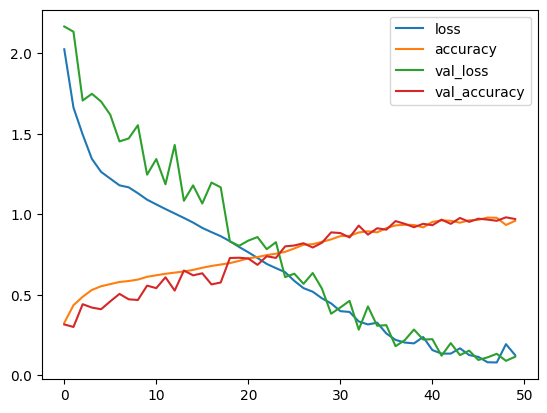

0.9812256693840027


In [13]:

model_ros_v2 = build_model_v2((X_ros.shape[1], 1))

ros_history_v2 = model_ros_v2.fit(X_ros, y_ros, validation_split=0.2, shuffle=True, epochs=50)

# summarize history for accuracy
pd.DataFrame(ros_history_v2.history).plot()
plt.show()

best_score = max(ros_history_v2.history['val_accuracy'])

print(best_score)

### Using merged dataset

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_merge, y_merge, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_merge_smote, y_merge_smote = smote.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_merge_ros, y_merge_ros = ros.fit_resample(X_train, y_train)

Epoch 1/50
707/707 [==============================] - 28s 31ms/step - loss: 1.8553 - accuracy: 0.3687 - val_loss: 1.8571 - val_accuracy: 0.3874
Epoch 2/50
707/707 [==============================] - 21s 29ms/step - loss: 1.4436 - accuracy: 0.4976 - val_loss: 1.5806 - val_accuracy: 0.5155
Epoch 3/50
707/707 [==============================] - 20s 28ms/step - loss: 1.2388 - accuracy: 0.5627 - val_loss: 1.3067 - val_accuracy: 0.5744
Epoch 4/50
707/707 [==============================] - 21s 29ms/step - loss: 1.1657 - accuracy: 0.5815 - val_loss: 1.3283 - val_accuracy: 0.5779
Epoch 5/50
707/707 [==============================] - 20s 28ms/step - loss: 1.0954 - accuracy: 0.6054 - val_loss: 1.1481 - val_accuracy: 0.6111
Epoch 6/50
707/707 [==============================] - 21s 29ms/step - loss: 1.0517 - accuracy: 0.6214 - val_loss: 1.0653 - val_accuracy: 0.6401
Epoch 7/50
707/707 [==============================] - 20s 28ms/step - loss: 1.0119 - accuracy: 0.6314 - val_loss: 1.4092 - val_accuracy:

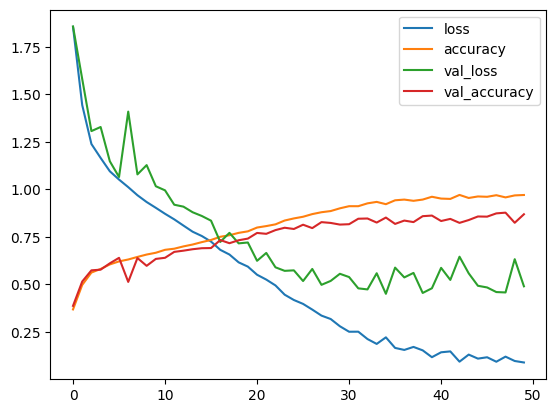

0.8778072595596313


In [15]:

model_smote_v3 = build_model_v2((X_merge_smote.shape[1], 1))
smote_history_v3 = model_smote_v3.fit(X_merge_smote, y_merge_smote, validation_split=0.2, shuffle=True, epochs=50)

pd.DataFrame(smote_history_v3.history).plot()
plt.show()

best_score = max(smote_history_v3.history['val_accuracy'])

print(best_score)

Epoch 1/50
707/707 [==============================] - 29s 31ms/step - loss: 1.8635 - accuracy: 0.3682 - val_loss: 2.2092 - val_accuracy: 0.2831
Epoch 2/50
707/707 [==============================] - 20s 28ms/step - loss: 1.4444 - accuracy: 0.4972 - val_loss: 1.6203 - val_accuracy: 0.4398
Epoch 3/50
707/707 [==============================] - 20s 28ms/step - loss: 1.2495 - accuracy: 0.5590 - val_loss: 1.6307 - val_accuracy: 0.4472
Epoch 4/50
707/707 [==============================] - 20s 28ms/step - loss: 1.1611 - accuracy: 0.5853 - val_loss: 1.3670 - val_accuracy: 0.5317
Epoch 5/50
707/707 [==============================] - 21s 29ms/step - loss: 1.1010 - accuracy: 0.6053 - val_loss: 1.2799 - val_accuracy: 0.5691
Epoch 6/50
707/707 [==============================] - 20s 28ms/step - loss: 1.0659 - accuracy: 0.6154 - val_loss: 1.4497 - val_accuracy: 0.4624
Epoch 7/50
707/707 [==============================] - 21s 29ms/step - loss: 1.0082 - accuracy: 0.6345 - val_loss: 1.3552 - val_accuracy:

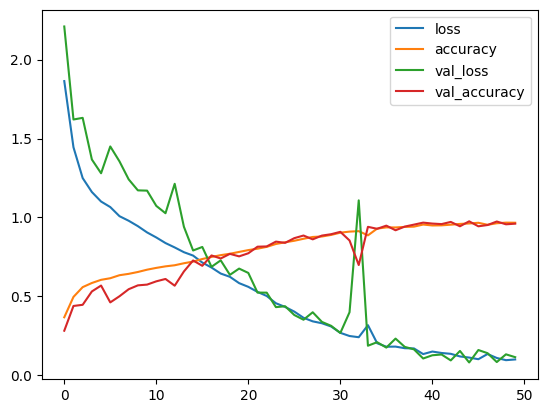

0.9757736325263977


In [16]:

model_ros_v3 = build_model_v2((X_merge_ros.shape[1], 1))
ros_history_v4 = model_ros_v3.fit(X_merge_ros, y_merge_ros, validation_split=0.2, shuffle=True, epochs=50)

pd.DataFrame(ros_history_v4.history).plot()
plt.show()

best_score = max(ros_history_v4.history['val_accuracy'])

print(best_score)

## Evaluated that ROS showed better results

### Using Merged Dataset

In [17]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_merge, y_merge, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_merge_full, y_merge_full = ros.fit_resample(X_train_full, y_train_full)

In [18]:

model_ros_full_GRU = build_model_GRU((X_merge_full.shape[1], 1))
model_ros_full_lstm = build_model_LSTM((X_merge_full.shape[1], 1))
model_ros_full_LSTM_GRU = build_model_LSTM_GRU((X_merge_full.shape[1], 1))

In [19]:
X_merge.head()

,Unnamed: 0,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,...,MEL124,MEL125,MEL126,MEL127,TONZ0,TONZ1,TONZ2,TONZ3,TONZ4,TONZ5
0,2581,-274.081064,90.553742,-1.319409,28.355147,-3.295721,4.588043,-4.467366,6.737204,-10.724703,...,0.000086,0.000085,0.000080,0.000078,-0.016402,-0.013311,-0.054505,0.011296,0.012550,0.009563
1,6466,-282.730691,71.540738,34.301680,11.759998,2.890566,-2.018548,-3.562313,-3.235804,-3.939426,...,0.000976,0.000892,0.000916,0.000897,0.041275,0.032079,0.008832,-0.025359,0.013441,0.032247
2,3673,-391.468786,86.299907,44.825176,37.441880,12.426751,7.889423,0.606896,2.038279,-4.524564,...,0.000043,0.000041,0.000043,0.000041,-0.005835,0.003289,-0.048369,-0.063204,0.011831,0.009074
3,21239,-471.930760,63.462643,13.026071,7.454551,7.756898,-2.243907,-15.625067,3.636577,-9.550095,...,0.000437,0.000529,0.000278,0.000023,-0.005725,0.030310,-0.053869,-0.018939,-0.024129,-0.016006
4,8315,-325.833235,65.936750,17.097764,19.950584,-0.243021,13.107857,4.477988,0.751412,-6.185140,...,0.000144,0.000141,0.000145,0.000145,-0.008370,-0.026442,-0.042298,0.055370,-0.000482,0.018563


Epoch 1/50
707/707 [==============================] - 21s 24ms/step - loss: 2.4464 - accuracy: 0.1796 - val_loss: 3.4299 - val_accuracy: 0.0476
Epoch 2/50
707/707 [==============================] - 15s 21ms/step - loss: 1.9813 - accuracy: 0.3306 - val_loss: 2.6905 - val_accuracy: 0.1866
Epoch 3/50
707/707 [==============================] - 15s 21ms/step - loss: 1.6137 - accuracy: 0.4458 - val_loss: 2.0582 - val_accuracy: 0.2842
Epoch 4/50
707/707 [==============================] - 15s 21ms/step - loss: 1.3261 - accuracy: 0.5403 - val_loss: 2.1712 - val_accuracy: 0.2914
Epoch 5/50
707/707 [==============================] - 15s 21ms/step - loss: 1.2162 - accuracy: 0.5759 - val_loss: 1.6045 - val_accuracy: 0.4829
Epoch 6/50
707/707 [==============================] - 15s 21ms/step - loss: 1.1336 - accuracy: 0.6011 - val_loss: 1.7492 - val_accuracy: 0.4352
Epoch 7/50
707/707 [==============================] - 16s 23ms/step - loss: 1.0777 - accuracy: 0.6195 - val_loss: 1.6702 - val_accuracy:

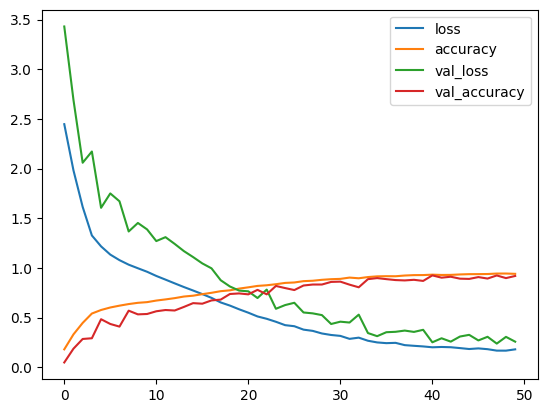

0.9429632425308228


In [20]:
ros_full_gru_history = model_ros_full_GRU.fit(X_merge_full, y_merge_full, validation_split=0.2, shuffle=True, epochs=50)
pd.DataFrame(ros_full_gru_history.history).plot()
plt.show()

best_score = max(ros_full_gru_history.history['accuracy'])

print(best_score)

Epoch 1/50
707/707 [==============================] - 22s 25ms/step - loss: 2.3442 - accuracy: 0.2024 - val_loss: 3.2122 - val_accuracy: 0.0223
Epoch 2/50
707/707 [==============================] - 15s 22ms/step - loss: 2.1976 - accuracy: 0.2536 - val_loss: 2.7971 - val_accuracy: 0.2062
Epoch 3/50
707/707 [==============================] - 15s 22ms/step - loss: 2.1531 - accuracy: 0.2726 - val_loss: 2.8122 - val_accuracy: 0.1795
Epoch 4/50
707/707 [==============================] - 16s 23ms/step - loss: 2.1587 - accuracy: 0.2826 - val_loss: 3.5742 - val_accuracy: 0.0000e+00
Epoch 5/50
707/707 [==============================] - 15s 22ms/step - loss: 2.4471 - accuracy: 0.1830 - val_loss: 3.6028 - val_accuracy: 0.0000e+00
Epoch 6/50
707/707 [==============================] - 17s 23ms/step - loss: 2.2453 - accuracy: 0.2565 - val_loss: 2.6119 - val_accuracy: 0.2633
Epoch 7/50
707/707 [==============================] - 15s 22ms/step - loss: 1.9951 - accuracy: 0.3374 - val_loss: 2.6502 - val_a

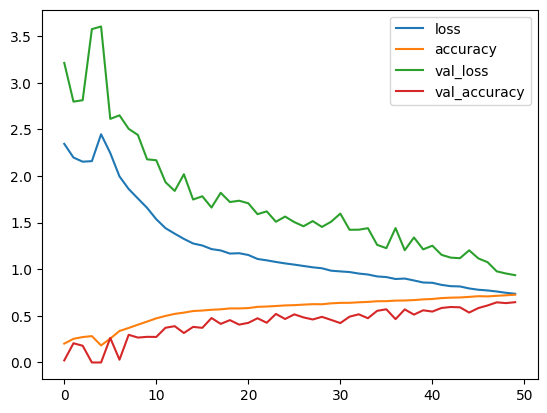

0.7266215682029724


In [21]:
ros_full_lstm_history = model_ros_full_lstm.fit(X_merge_full, y_merge_full, validation_split=0.2, shuffle=True, epochs=50)
pd.DataFrame(ros_full_lstm_history.history).plot()
plt.show()

best_score = max(ros_full_lstm_history.history['accuracy'])

print(best_score)

Epoch 1/50
707/707 [==============================] - 22s 23ms/step - loss: 2.3804 - accuracy: 0.1931 - val_loss: 3.0066 - val_accuracy: 0.0805
Epoch 2/50
707/707 [==============================] - 15s 21ms/step - loss: 1.8720 - accuracy: 0.3701 - val_loss: 2.5841 - val_accuracy: 0.1896
Epoch 3/50
707/707 [==============================] - 15s 21ms/step - loss: 1.5530 - accuracy: 0.4665 - val_loss: 2.2319 - val_accuracy: 0.2769
Epoch 4/50
707/707 [==============================] - 15s 21ms/step - loss: 1.3393 - accuracy: 0.5317 - val_loss: 1.9373 - val_accuracy: 0.3531
Epoch 5/50
707/707 [==============================] - 16s 22ms/step - loss: 1.2209 - accuracy: 0.5655 - val_loss: 1.8469 - val_accuracy: 0.3503
Epoch 6/50
707/707 [==============================] - 15s 21ms/step - loss: 1.1536 - accuracy: 0.5876 - val_loss: 1.6433 - val_accuracy: 0.4191
Epoch 7/50
707/707 [==============================] - 15s 21ms/step - loss: 1.1057 - accuracy: 0.6033 - val_loss: 1.5131 - val_accuracy:

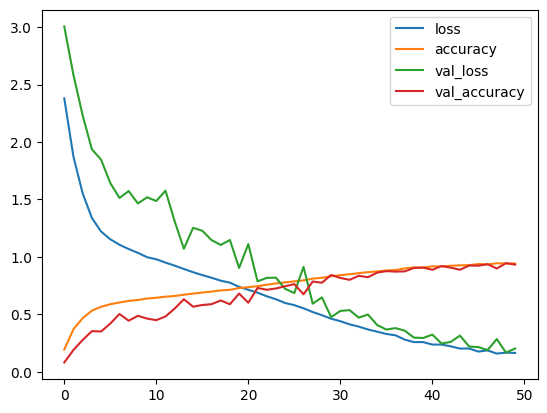

0.9442896842956543


In [22]:
ros_full_lstm_gru_history = model_ros_full_LSTM_GRU.fit(X_merge_full, y_merge_full, validation_split=0.2, shuffle=True, epochs=50)
pd.DataFrame(ros_full_lstm_gru_history.history).plot()
plt.show()

best_score = max(ros_full_lstm_gru_history.history['accuracy'])

print(best_score)

In [23]:
print(max(ros_full_gru_history.history['val_accuracy']), max(ros_full_lstm_history.history['val_accuracy']), max(ros_full_lstm_gru_history.history['val_accuracy']))

0.9243147373199463 0.6465075016021729 0.945004403591156


In [24]:
def create_model(input_shape, hidden_size, learning_rate, num_classes=16):

    model = keras.Sequential()
    model.add(GRU(units=hidden_size, return_sequences=True, input_shape=input_shape))
    model.add(GRU(units=hidden_size, return_sequences=True, input_shape=input_shape))
    model.add(GRU(units=hidden_size))

    model.add(Dense(num_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    # Use categorical crossentropy if labels are one hot encoded
    # Use sparse categorical crossentropy if labels are label encoded meaning they are represented by integers
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Set the batch_size parameter for model.fit
    model.batch_size = 32

    return model

def create_model_final(input_shape, hidden_size, learning_rate,):
    model = keras.Sequential()
    model.add(GRU(units=hidden_size, return_sequences=True, input_shape=input_shape))
    model.add(GRU(units=hidden_size, return_sequences=True, input_shape=input_shape))
    model.add(GRU(units=hidden_size))
    model.add(Dense(16, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# #X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_merge_full, y_merge_full, test_size=0.2, random_state=42)
# X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# # Define the hyperparameters search space
# hyperparam_distribution_range = {
#     'learning_rate': [0.0001, 0.001],
#     'hidden_size': [128]
# }

# best_accuracy = 0.0
# best_hyperparameters = {}

# for learning_rate in hyperparam_distribution_range['learning_rate']:
#     for hidden_size in hyperparam_distribution_range['hidden_size']:
#         print(hidden_size, learning_rate)
#         # Build the model
#         model = create_model_final((X_train_val.shape[1],1), hidden_size, learning_rate)

#         # Train the model
#         model.fit(X_train_val, y_train_val, epochs=100, verbose=0)

#         # Evaluate the model on the test data
#         test_loss, test_acc = model.evaluate(X_test_val, y_test_val)

#         # Check if this model has the best accuracy so far
#         if test_acc > best_accuracy:
#             best_accuracy = test_acc
#             best_hyperparameters = {
#                 'hidden_size': hidden_size,
#                 'learning_rate': learning_rate,
#             }

# # Print the best hyperparameters and accuracy
# print("Best Hyperparameters:")
# print(best_hyperparameters)
# print("Best Accuracy:", best_accuracy)

Epoch 1/50
884/884 [==============================] - 22s 20ms/step - loss: 2.4488 - accuracy: 0.1845
Epoch 2/50
884/884 [==============================] - 18s 20ms/step - loss: 1.8744 - accuracy: 0.3744
Epoch 3/50
884/884 [==============================] - 17s 19ms/step - loss: 1.4940 - accuracy: 0.4872
Epoch 4/50
884/884 [==============================] - 17s 19ms/step - loss: 1.2863 - accuracy: 0.5565
Epoch 5/50
884/884 [==============================] - 18s 20ms/step - loss: 1.1620 - accuracy: 0.5919
Epoch 6/50
884/884 [==============================] - 17s 19ms/step - loss: 1.0791 - accuracy: 0.6185
Epoch 7/50
884/884 [==============================] - 17s 19ms/step - loss: 1.0244 - accuracy: 0.6387
Epoch 8/50
884/884 [==============================] - 18s 20ms/step - loss: 0.9741 - accuracy: 0.6534
Epoch 9/50
884/884 [==============================] - 17s 19ms/step - loss: 0.9353 - accuracy: 0.6658
Epoch 10/50
884/884 [==============================] - 17s 19ms/step - loss: 0.887

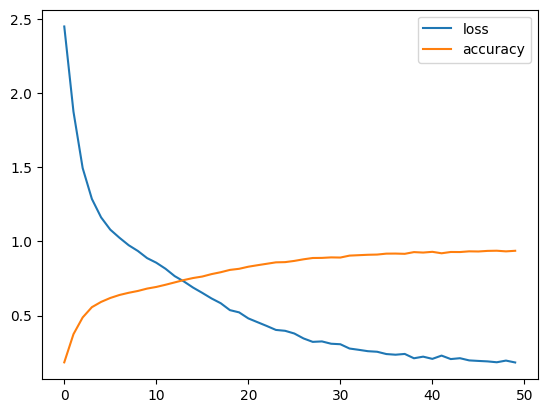

In [32]:

final_ros_model = create_model_final((X_merge_full.shape[1],1), 128, 0.001)


final_ros_history = final_ros_model.fit(X_merge_full, y_merge_full, epochs=50)
pd.DataFrame(final_ros_history.history).plot()
plt.show()

In [33]:
loss, acc = final_ros_model.evaluate(X_test_full, y_test_full)
print(f"Test accuracy: {acc:.4f}")
final_ros_model.save('final_ros_model.keras')

147/147 [==============================] - 2s 9ms/step - loss: 1.9143 - accuracy: 0.5934
Test accuracy: 0.5934


In [34]:
# load model
from keras.models import load_model

# Load the saved model
loaded_model = load_model("final_ros_model.keras")

147/147 [==============================] - 2s 8ms/step


Text(0.5, 58.5815972222222, 'Predicted emotion')

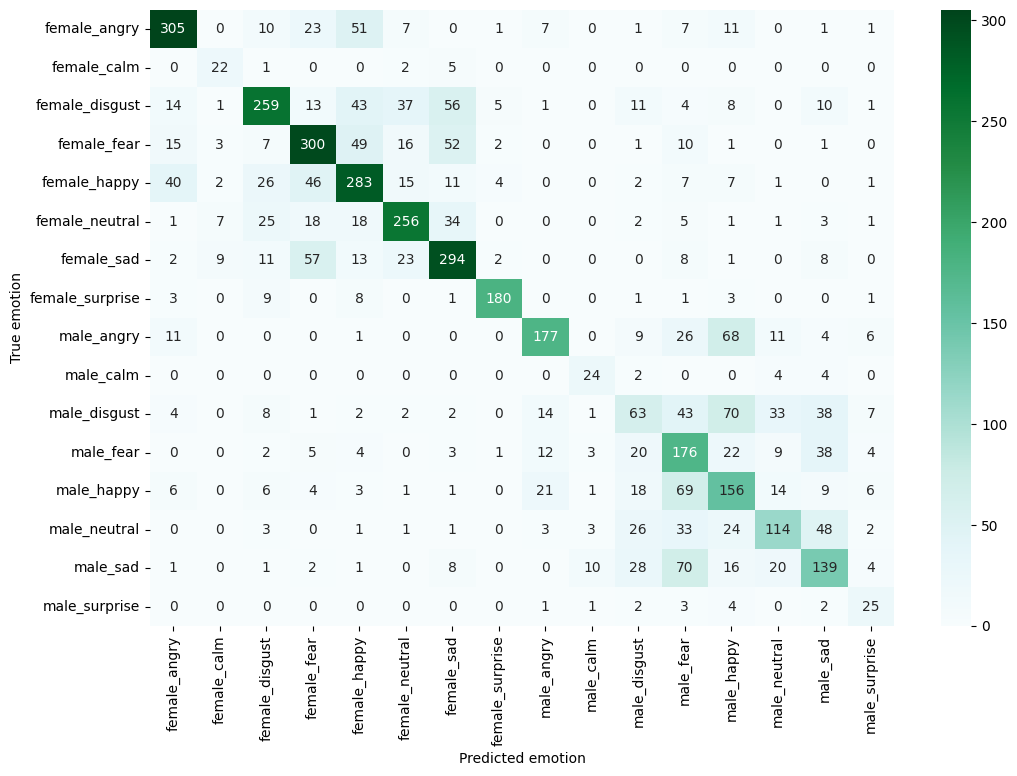

In [35]:
from sklearn.metrics import confusion_matrix

# Get predicted labels
y_pred = final_ros_model.predict(X_test_full)
y_pred_class = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_full, y_pred_class)

index = ['female_angry', 'female_calm', 'female_disgust', 'female_fear', 'female_happy', 'female_neutral', 'female_sad', 'female_surprise',
         'male_angry', 'male_calm', 'male_disgust', 'male_fear', 'male_happy', 'male_neutral', 'male_sad', 'male_surprise']
columns = ['female_angry', 'female_calm', 'female_disgust', 'female_fear', 'female_happy', 'female_neutral', 'female_sad', 'female_surprise',
         'male_angry', 'male_calm', 'male_disgust', 'male_fear', 'male_happy', 'male_neutral', 'male_sad', 'male_surprise']


# Plot confusion matrix
cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_test_full, y_pred_class, average='weighted')
recall = recall_score(y_test_full, y_pred_class, average='weighted')
f1 = f1_score(y_test_full, y_pred_class, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

print("\n")

# For a detailed classification report including precision, recall, f1-score per class
print(classification_report(y_test_full, y_pred_class, target_names=index))

Precision: 0.6056345400268779, Recall: 0.59340894500321, F1-Score: 0.594203549681951


                 precision    recall  f1-score   support

   female_angry       0.76      0.72      0.74       425
    female_calm       0.50      0.73      0.59        30
 female_disgust       0.70      0.56      0.62       463
    female_fear       0.64      0.66      0.65       457
   female_happy       0.59      0.64      0.61       445
 female_neutral       0.71      0.69      0.70       372
     female_sad       0.63      0.69      0.66       428
female_surprise       0.92      0.87      0.90       207
     male_angry       0.75      0.57      0.64       313
      male_calm       0.56      0.71      0.62        34
   male_disgust       0.34      0.22      0.27       288
      male_fear       0.38      0.59      0.46       299
     male_happy       0.40      0.50      0.44       315
   male_neutral       0.55      0.44      0.49       259
       male_sad       0.46      0.46      0.46       300


In [37]:
# import metrics from sklearn library
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Possible values for average paramter: micro, macro, weighted, samples

# Compute accuracy
accuracy = accuracy_score(y_test_full, y_pred_class)
print(f'Accuracy: {accuracy}')

# Compute precision
precision = precision_score(y_test_full, y_pred_class, average='weighted')
print(f'Precision: {precision}')

# Compute recall
recall = recall_score(y_test_full, y_pred_class, average='weighted')
print(f'Recall: {recall}')

# Compute F1 score
f1 = f1_score(y_test_full, y_pred_class, average='weighted')
print(f'F1-score: {f1}')

Accuracy: 0.59340894500321
Precision: 0.6056345400268779
Recall: 0.59340894500321
F1-score: 0.594203549681951


In [38]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
female_angry : 0.7176
female_calm : 0.7333
female_disgust : 0.5594
female_fear : 0.6565
female_happy : 0.6360
female_neutral : 0.6882
female_sad : 0.6869
female_surprise : 0.8696
male_angry : 0.5655
male_calm : 0.7059
male_disgust : 0.2188
male_fear : 0.5886
male_happy : 0.4952
male_neutral : 0.4402
male_sad : 0.4633
male_surprise : 0.6579


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b28ef1e-f6a6-4523-8903-70adcffed1c5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>